minermonitoring.com has real benchmarks submitted by users. We can parse their benchmarks and compute:

1. The relationship between power and hashrate, identifying GPUs that are more or less efficient than most.
2. The distribution of hashrate efficiencies across all samples, and the median efficiency.
3. The median hashrate and power per-GPU, to be used in other work.

In [78]:
from bs4 import BeautifulSoup
from utils.list_files import list_files
from utils.progress import progress
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

plt.rcParams['font.size'] = 20

In [60]:
samples = []
cols = ['gpu', 'hashrate', 'algo', 'core', 'memory', 'power', 'software', 'driver', 'version']
for fn in progress(list_files('minermonitoring.com', 'html')):
    with open(fn) as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    for row in soup.find('tbody').findAll('tr'):
        sample = dict(zip(cols, [e.text for e in row.findAll('td')]))
        samples.append(sample)

480 0:00:15 32.48/s


In [61]:
len(samples)

9550

In [70]:
# throw out some very high or very low numbers that are probably glitches
min_valid_power = 10
min_valid_hashrate = 10
max_valid_hashrate = 80

In [71]:
all_power = []
grouped = defaultdict(list)
for sample in samples:
    hashrate = float(sample['hashrate'].split(' ')[0])
    power = float(sample['power'].split('W')[0])
    if hashrate > max_valid_hashrate or hashrate < min_valid_hashrate or power < min_valid_power:
        continue
    all_power.append(power)
    grouped[sample['gpu']].append((hashrate, power))
grouped = dict(grouped)

In [72]:
e = np.asarray(all_power)
# e[(e > 50) & (e < 200)].mean()
e[e>50].mean()

118.58380714123265

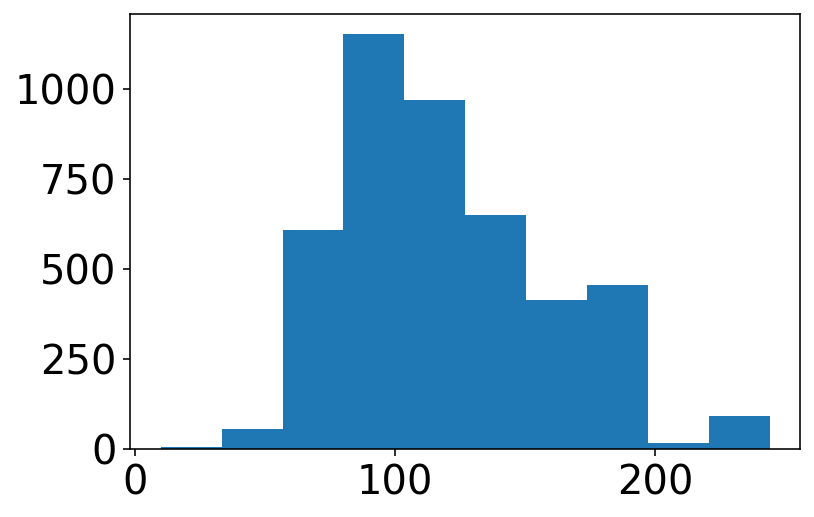

109.0

In [73]:
plt.hist(all_power, bins=10)
plt.show()
np.median(all_power)

In [74]:
def clean_label(label):
    return label\
        .replace('GeForce ', '')\
        .replace('Radeon ', '')\
        .replace('Innosilicon ', '')\
        .replace('Nvidia ','')\
        .replace('GTX ', '')\
        .replace('RTX ', '')\
        .replace('CMP ', '')\
        .replace(' ETHMiner', '')\
        .replace(' ETHMaster', '')\
        .replace(' 2GB', '')\
        .replace(' 6GB', '')\
        .replace(' 8GB', '')\
        .replace(' Super', 'S')\
        .replace('RX ', 'RX')\
        .replace('(TM) ', '')\
        .replace(' SUPER', 'S')\
        .replace(' Ti', 'Ti')\
        .replace(' Graphics', '')

In [75]:
# counts/800

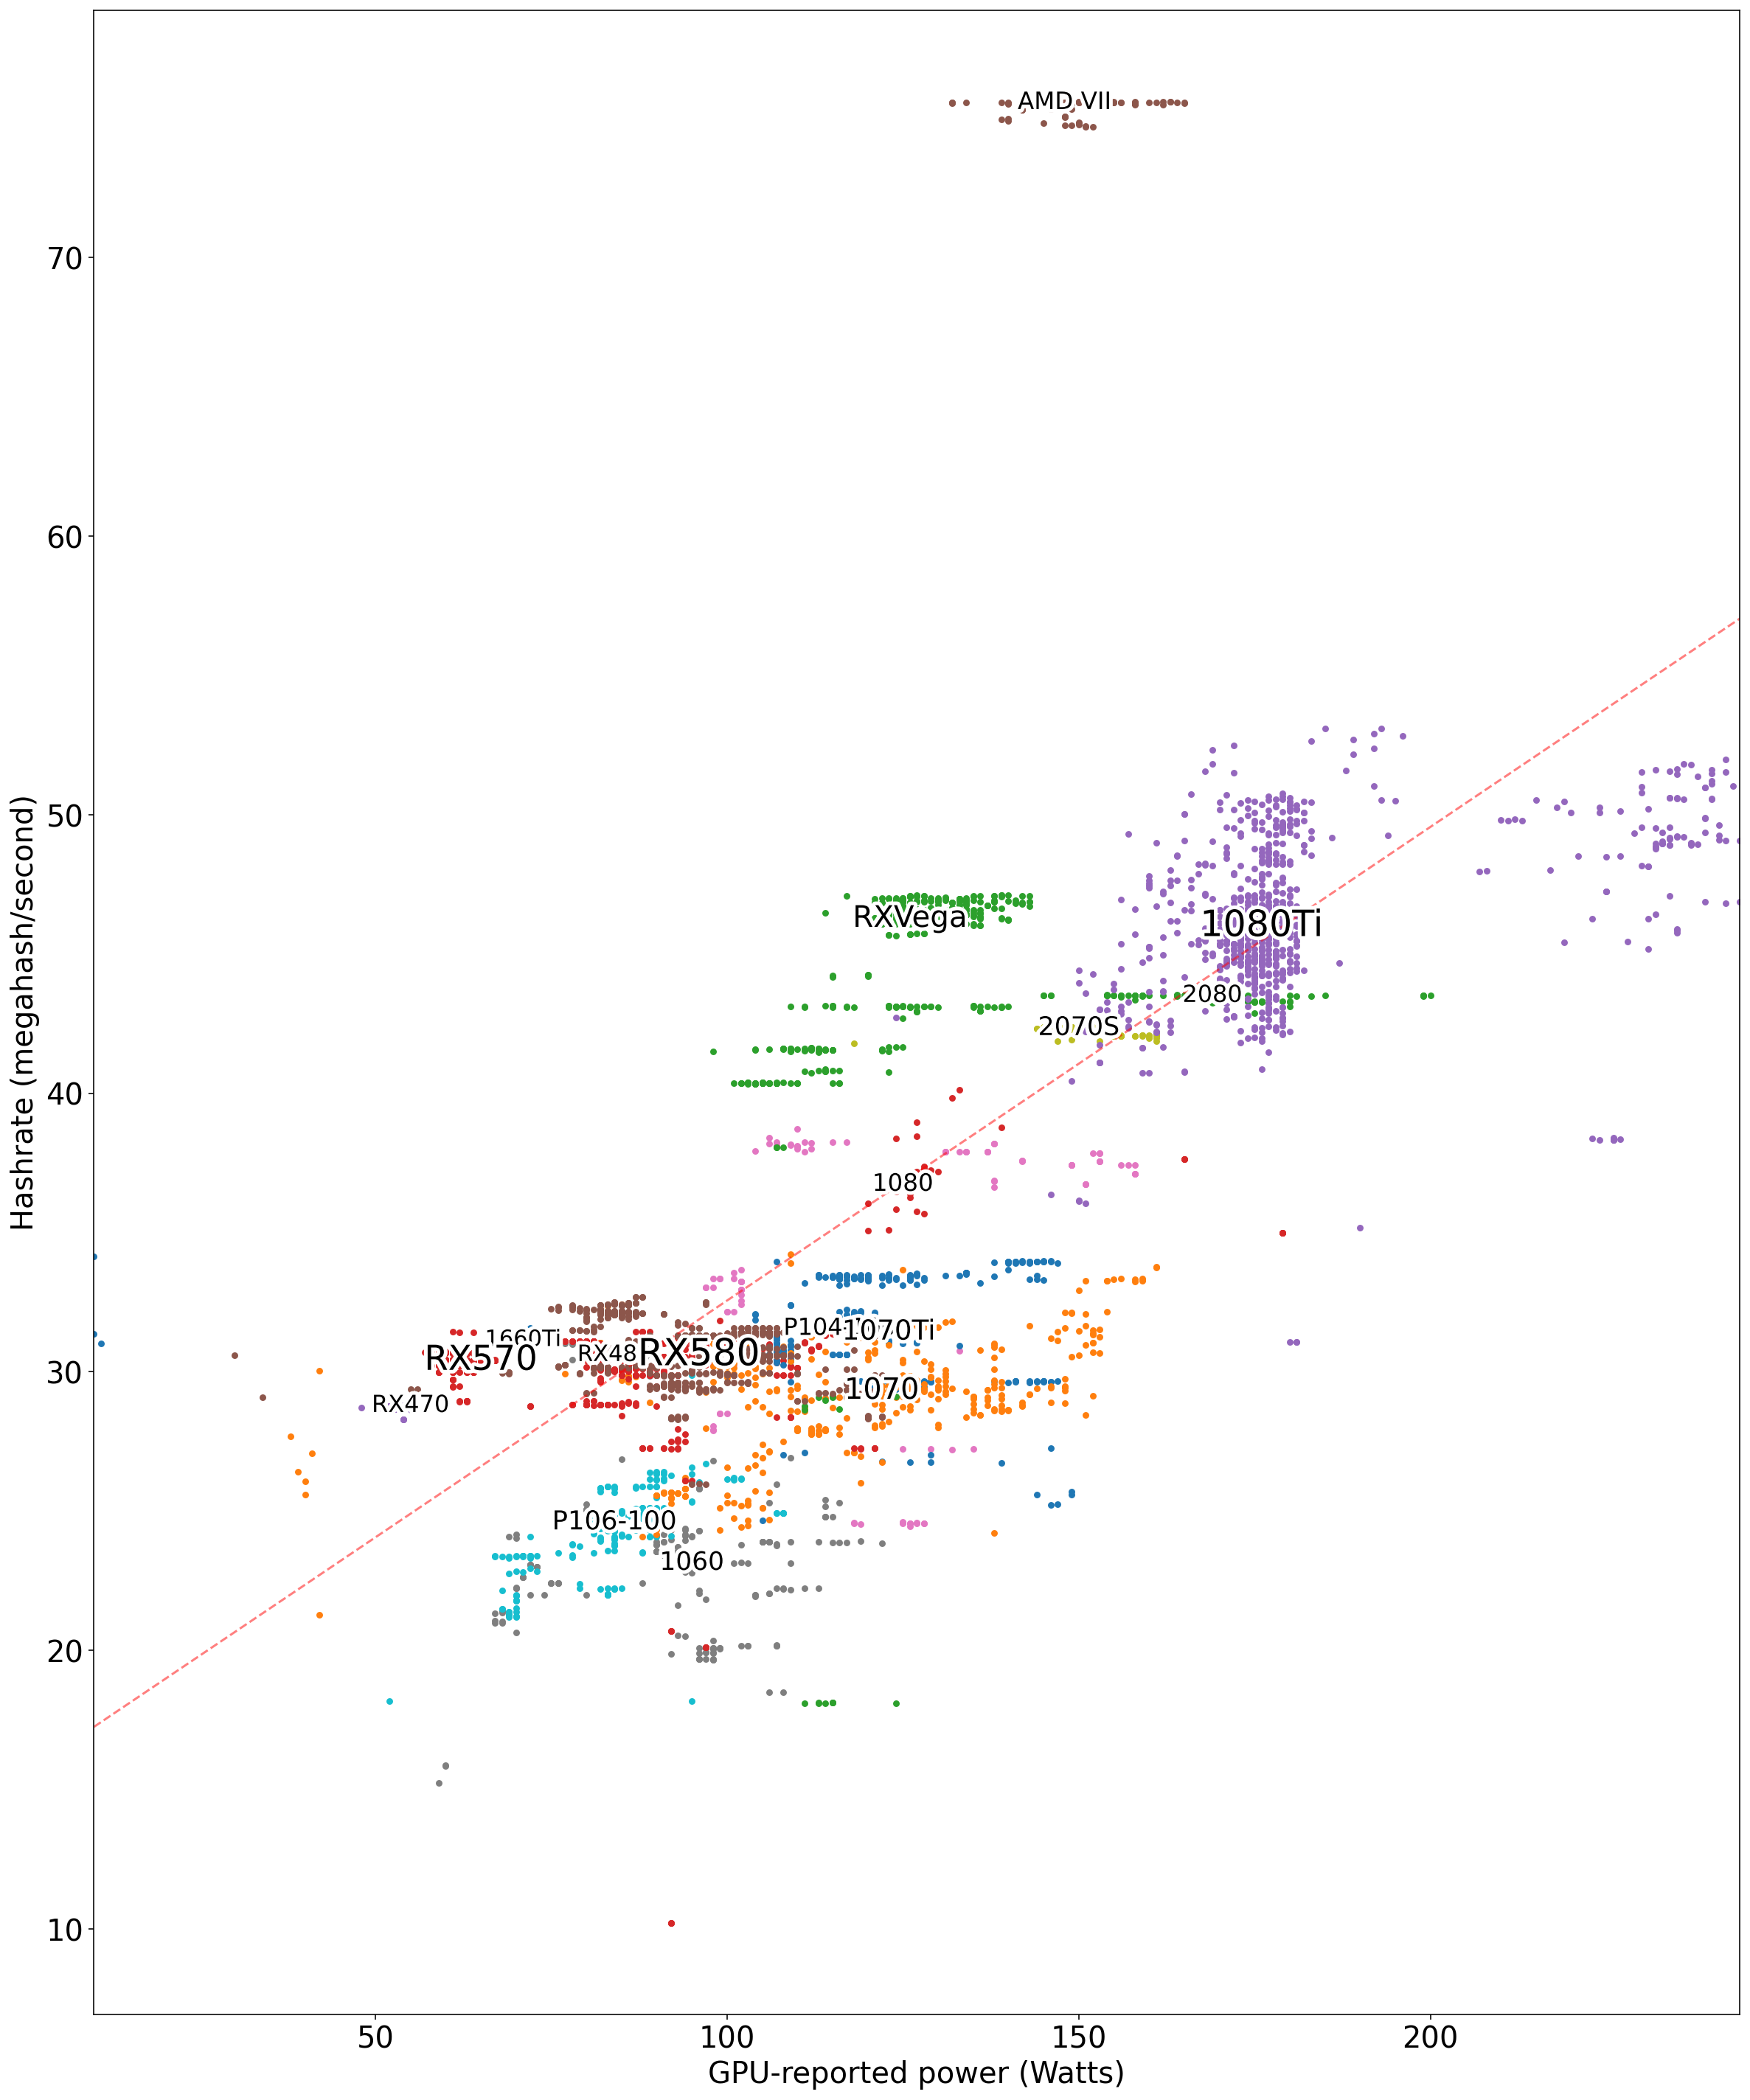

In [80]:
effects = [path_effects.Stroke(linewidth=5, foreground='white'), path_effects.Normal()]

plt.figure(figsize=(20,25), facecolor='white')
pts = []

counted = sorted([(len(v),k,v) for k,v in grouped.items()], reverse=False)

for c,k,v in counted:
    name = clean_label(k)
    hashrates, powers = zip(*v)
    x = powers
    y = hashrates
    plt.scatter(x, y, label=k, lw=0, s=20)
    medx = np.median(x)
    medy = np.median(y)
    fontsize = 15 + 10 * (c / 800)
    text = plt.text(medx, medy, name, fontsize=fontsize, ha='center', va='center')
    text.set_path_effects(effects)
    for px,py in zip(x, y):
        pts.append((px, py))
        
xs,ys = zip(*pts)
z = np.polyfit(xs, ys, 1)
p = np.poly1d(z)
xs = [min(xs), max(xs)]
plt.plot(xs, p(xs),'r--', alpha=0.5)
# plt.title('minermonitoring.com benchmarks power vs hashrate')
plt.xlabel('GPU-reported power (Watts)')
plt.ylabel('Hashrate (megahash/second)')
plt.xlim(xs)
# plt.ylim(15,55)
# plt.legend(markerscale=5)
plt.show()

In [77]:
z

array([ 0.17002956, 15.5524836 ])

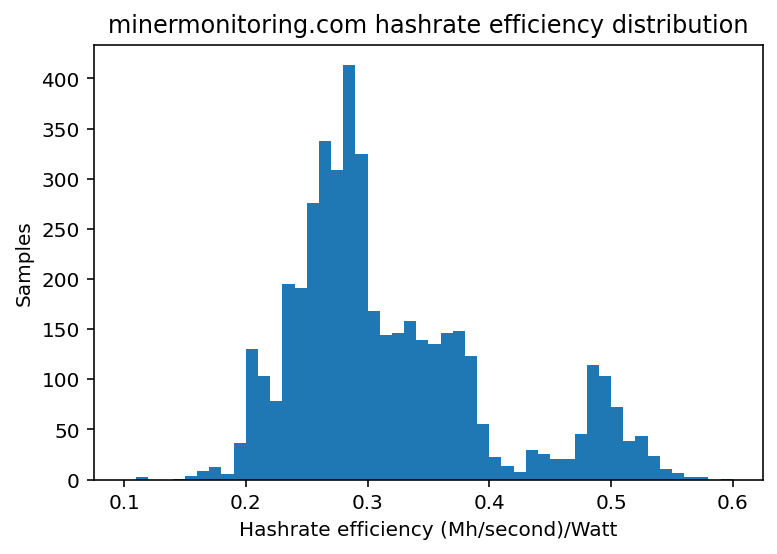

In [10]:
xs,ys = zip(*pts)
efficiencies = np.divide(ys,xs)
plt.hist(efficiencies, bins=50, range=(0.1,0.6))
plt.title('minermonitoring.com hashrate efficiency distribution')
plt.xlabel('Hashrate efficiency (Mh/second)/Watt')
plt.ylabel('Samples')
plt.show()

In [9]:
np.median(efficiencies)

0.29346153846153844

In [11]:
for i,(k,v) in enumerate(grouped.items()):
    hashrates, powers = zip(*v)
    median_power = np.median(powers)
    median_hashrate = np.median(hashrates)
    print('\t'.join([k,str(median_power),str(median_hashrate)]))

GeForce GTX 1070	122.0	29.32
GeForce GTX 1060 6GB	95.0	23.14
Radeon RX 580	96.0	30.605
GeForce GTX 1070 Ti	123.0	31.42
P106-100	84.0	24.604999999999997
GeForce GTX 1080	125.0	36.72
GeForce GTX 1080 Ti	176.0	46.01
P104-100	116.0	31.55
GeForce RTX 2070 SUPER	150.0	42.35
GeForce RTX 2080	169.0	43.5
Radeon RX 570	65.0	30.4
Radeon (TM) RX 480 Graphics	84.0	30.61
Radeon RX Vega	126.0	46.26
AMD Radeon VII	148.0	75.55
Radeon (TM) RX 470 Graphics	55.0	28.78
GeForce GTX 1660 Ti	71.0	31.15
